# Training of letters for CLEMSite

## Using Convolutional Neural Networks 

---

In this notebook, we train a CNN to recognise characters

### 1. Load dataset and split for training,validation and test.

In [1]:
import keras
import numpy as np
from keras.utils import np_utils
from sklearn.datasets import load_files 
from sklearn.model_selection import train_test_split

def load_dataset(path):
    data = load_files(path)
    letter_files = np.array(data['filenames'])
    letter_targets = np_utils.to_categorical(np.array(data['target']), 36)
    return letter_files, letter_targets


letter_files, letter_targets = load_dataset('C:\\Users\\JMS\\PycharmProjects\\letters\\Fnt2')
# Split in train, valid and targets
x_train, x_test, y_train, y_test = train_test_split(letter_files, letter_targets, test_size=0.2, random_state=1)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

Using TensorFlow backend.


2928 train samples
916 test samples
733 validation samples


### 2. Visualize the First 24 Training Images

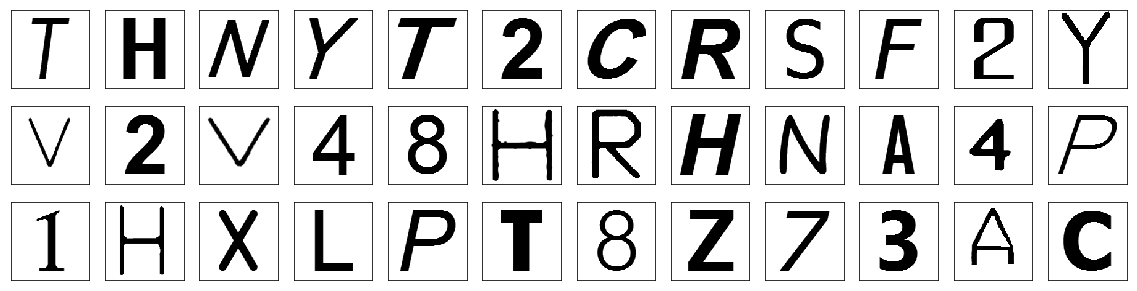

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    img = cv2.imread(x_train[i])
    ax.imshow(np.squeeze(img))

### 3. Invert, apply gradient and rescale the images  255.
Gradient is applied to simulate the same conditions as images taken,after that,normalization is applied.

In [3]:
from keras.preprocessing import image                  
from tqdm import tqdm
from skimage import data, io, filters

def path_to_tensor(img_path):
    img = cv2.imread(img_path,0)
    img = (img<255)*255 # invert
    final = filters.sobel(img)
    final = cv2.resize(final,(128,128))
    final = np.array((final > np.min(final)),dtype=np.float32)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 1) and return 4D tensor
    return np.expand_dims(final, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

train_tensors = paths_to_tensor(x_train)
valid_tensors = paths_to_tensor(x_valid)
test_tensors = paths_to_tensor(x_test)

100%|██████████| 916/916 [00:01<00:00, 580.44it/s]


### 4.  Load images

In [4]:
train_tensors = np.expand_dims(train_tensors, axis=3)
valid_tensors = np.expand_dims(valid_tensors, axis=3)
test_tensors = np.expand_dims(test_tensors, axis=3)

### 5. Create and Configure Augmented Image Generator

In [5]:
# create and configure augmented image generator
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        zoom_range=0.05,
        horizontal_flip=True,
        fill_mode='nearest')


# fit augmented image generator on data
datagen.fit(train_tensors)

### 6. Visualize Original and Augmented Images

100%|██████████| 12/12 [00:00<00:00, 461.13it/s]


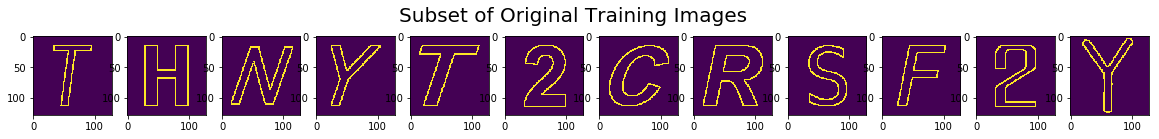

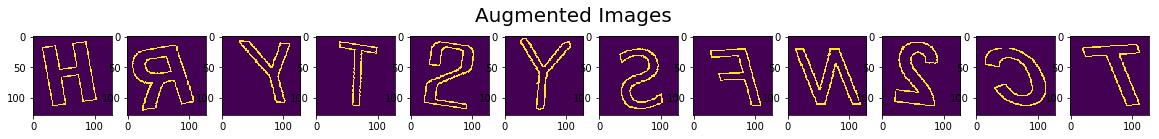

In [6]:
import matplotlib.pyplot as plt

# take subset of training data
x_train_subset = paths_to_tensor(x_train[:12])

# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(x_train_subset[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

# visualize augmented images
fig = plt.figure(figsize=(20,2))
for x_batch in datagen.flow(train_tensors[:12], batch_size=12):
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(x_batch[i,:,:,0])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;

### 7. Define the Model Architecture 

In [7]:

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', 
                        input_shape=(128, 128, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))

# model.add(Flatten())
model.add(GlobalAveragePooling2D())
model.add(Dense(192, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(36, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 64)        256       
__________

### 8. Compile the Model 

In [8]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

### 9. Train the Model 

In [9]:

from keras.callbacks import ModelCheckpoint   

batch_size = 20
epochs = 50

# train the model
checkpointer = ModelCheckpoint(filepath='letters_model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
   

    
hist = model.fit_generator(
        datagen.flow(train_tensors, y_train,batch_size=batch_size),
        steps_per_epoch= y_train.shape[0] // batch_size,
        epochs=epochs,
        verbose =2,
        callbacks = [checkpointer],
        validation_data= datagen.flow(valid_tensors, y_valid,batch_size=batch_size),
        validation_steps= y_valid.shape[0] // batch_size)


Epoch 1/50
Epoch 00000: val_loss improved from inf to 7.83717, saving model to letters_model.weights.best.hdf5
278s - loss: 2.8784 - acc: 0.2106 - val_loss: 7.8372 - val_acc: 0.0361
Epoch 2/50
Epoch 00001: val_loss did not improve
278s - loss: 1.7426 - acc: 0.4659 - val_loss: 12.1361 - val_acc: 0.0266
Epoch 3/50
Epoch 00002: val_loss improved from 7.83717 to 5.75378, saving model to letters_model.weights.best.hdf5
280s - loss: 1.1717 - acc: 0.6269 - val_loss: 5.7538 - val_acc: 0.1010
Epoch 4/50
Epoch 00003: val_loss improved from 5.75378 to 1.04325, saving model to letters_model.weights.best.hdf5
279s - loss: 0.8697 - acc: 0.7295 - val_loss: 1.0432 - val_acc: 0.6858
Epoch 5/50
Epoch 00004: val_loss improved from 1.04325 to 0.50317, saving model to letters_model.weights.best.hdf5
280s - loss: 0.7220 - acc: 0.7714 - val_loss: 0.5032 - val_acc: 0.8513
Epoch 6/50
Epoch 00005: val_loss improved from 0.50317 to 0.28766, saving model to letters_model.weights.best.hdf5
279s - loss: 0.5549 - ac

### 10. Load the Model with the Best Validation Accuracy

In [11]:
# load the weights that yielded the best validation accuracy
model.load_weights('letters_model.weights.best.hdf5')

### 11. Calculate Classification Accuracy on Test Set

In [12]:
# get index of predicted dog breed for each image in test set
letter_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

In [13]:
# report test accuracy
test_accuracy = 100*np.sum(np.array(letter_predictions)==np.argmax(y_test, axis=1))/len(y_test)
print('Test accuracy: %.4f%%' % test_accuracy)
# evaluate and print test accuracy
score = model.evaluate(test_tensors, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])

Test accuracy: 99.4541%

 Test accuracy: 0.994541484716


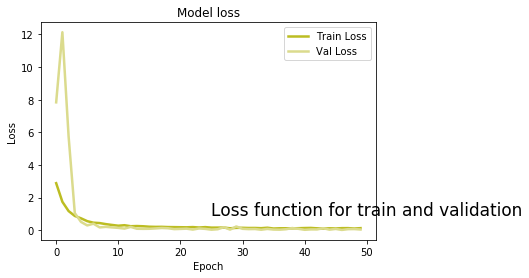

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  

for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)  
    
plt.plot(hist.epoch, hist.history['loss'], lw=2.5, color=tableau20[16])    
plt.plot(hist.epoch, hist.history['val_loss'], lw=2.5, color=tableau20[17])  
plt.text(50, 0.9, "Loss function for train and validation", fontsize=17, ha="center")  
plt.legend(['Train Loss', 'Val Loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')